In [1]:
from vncorenlp import VnCoreNLP
import pandas as pd
import re
import seaborn as sns
import numpy as np
from pyvi import ViTokenizer
import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from collections import Counter
from string import punctuation
import json
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
rdrsegmenter = VnCoreNLP("VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg,pos,ner", max_heap_size='-Xmx2g')

In [3]:
macp = pd.read_excel('data/Macp.xlsx')
macp = macp.dropna()
tenct = macp['Tên Công ty'].tolist()
for i in range(len(tenct)):
  tenct[i] = str(tenct[i]).lower()
#tenct[:5]
tenma = macp['Mã '].tolist()

def del_test(text):
  year = ['năm 2021', 'năm 2020', 'năm 2019', 'năm 2018', 'năm 2017', 'năm 2016', 'năm 2015', 'năm 2014', 'năm 2013', 'năm 2012', 'năm 2011', 'năm 2010', 'Năm 2021', 'Năm 2020', 'Năm 2019', 'Năm 2018', 'Năm 2017', 'Năm 2016', 'Năm 2015', 'Năm 2014', 'Năm 2013', 'Năm 2012', 'Năm 2011', 'Năm 2010', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']
  month = ['tháng 1', 'tháng 2', 'tháng 3', 'tháng 4', 'tháng 5', 'tháng 6', 'tháng 7', 'tháng 8', 'tháng 9', 'tháng 10', 'tháng 11', 'tháng 12', 'Tháng 1', 'Tháng 2', 'Tháng 3', 'Tháng 4', 'Tháng 5', 'Tháng 6', 'Tháng 7', 'Tháng 8', 'Tháng 9', 'Tháng 10', 'Tháng 11', 'tháng 12']
  quy = ['quý 1', 'quý 2', 'quý 3', 'quý 4', 'Quý 1', 'Quý 2', 'Quý 3', 'Quý 4']
  text = text.replace('Covid-19', 'Covid')

  word_segmented_text = rdrsegmenter.ner(text)[0]

  for char, typ in word_segmented_text:
    if typ == 'B-ORG' or typ == 'I-ORG' or typ == 'B-PER' or typ == 'I-PER':
      char = char.replace('_', ' ')
      text = text.replace(char, 'name')

    if typ == "B-LOC" or typ == "I-LOC":
      if char != 'VN':
        char = char.replace('_', ' ')
        text = text.replace(char,'loc')

    if typ == 'O':
      if len(re.findall('\d*\.?\,?\d+\%', char)) > 0:
        text = text.replace(char, 'percent')
      if len(re.findall('\s?\(?[A-Z]{3,4}\)?\s?', char)) > 0 and char != 'USD':
          text = text.replace(char, 'name')
      if char in tenma:
        text = text.replace(char, 'name')

      char = char.replace('_', ' ')
      char_lower = char.lower()
      if char_lower in tenct:
        text = text.replace(char, 'name')

  text = text.replace('"', '')
  text = text.replace('”', '')
  text = text.replace('“', '')
  text = text.replace('.', '')
  text = text.replace(',', '')
  text = text.replace('(', '')
  text = text.replace(')', '')
  text = text.replace(':', '')
  text = text.replace('[', '')
  text = text.replace(']', '')
  text = text.replace('-', ' ')

  for i in punctuation:
    text = text.replace(i, '')

  text = re.sub('\d{0,2}-?\d{0,2}\/\d{1,4}', 'date', text)
  for i in quy:
    text = text.replace(i, 'date')
  for i in year:
    text = text.replace(i, 'date')
  for i in month:
    text = text.replace(i, 'date')
  text = re.sub('\d+ năm ', 'date ', text)
  text = re.sub('\d+ tháng ', 'date ', text)
  text = re.sub(' \-?\d+\w?', ' number', text)
  text = text.split()
  for i in range(len(text)):
    if text[i].isdigit():
      text[i] = 'number'
  text = ' '.join(text)
  text1 = text.split()
  for i in range(len(text1)+1):
    try:
      if text1[i][0].isupper() and text1[i+1][0].isupper():
        text = text.replace(text1[i], 'name')
        text = text.replace(text1[i+1], 'name')
    except:
      pass
  text = rdrsegmenter.tokenize(text)
  text = ' '.join([' '.join(x) for x in text])
  text = text.lower()
  return text

In [4]:
df1 = pd.read_excel('data/raw_data-1.xlsx')
df2 = pd.read_excel('data/sample_sentence.xlsx')

df2.label.replace('n', 1, inplace=True)
df2.label.replace('p', 3, inplace=True)

In [5]:
data = pd.concat([df1,df2], ignore_index=True)
data.head(10)

,title,label
0,"""Trùm"" logistics Sotrans lên kế hoạch tăng gấp...",3
1,"ĐHĐCĐ SSI: ""Khen ngợi CTCK thị phần số 1, nhưn...",2
2,Cổ phiếu nhóm Viettel giảm mạnh dù thị trường ...,2
3,"Cổ phiếu lên đỉnh, con gái chủ tịch Haxaco (HA...",2
4,"FPT: Cổ phiếu bứt phá 59%, lãi ròng 4 tháng đầ...",3
5,"Soi lợi nhuận quý 1 của các cổ phiếu ""hàng hiệu""",2
6,"SP mua lại 49% cổ phần Skylar từ BCG Energy, x...",3
7,DIC Corp (DIG) dự kiến phát hành gần 60 triệu ...,3
8,Sự vực dậy sau hàng thập kỷ của những thương h...,3
9,8 sai lầm kể cả nhà đầu tư chứng khoán lâu năm...,2


In [6]:
# new_title = []
# title = data['title'].tolist()
# for i in title:
#   new_title.append(del_test(i))
# new_title

In [7]:
# new_data = pd.DataFrame()
# new_data['title'] = new_title
# new_data['label'] = data['label']
# new_data

In [8]:
new_data = pd.read_csv('data/train_sample.csv')
new_data

,title,label
0,trùm logistics name lên kế_hoạch tăng gấp đôi ...,3
1,đhđcđ name khen_ngợi name thị_phần số number n...,2
2,cổ_phiếu nhóm name giảm mạnh dù thị_trường lên...,2
3,cổ_phiếu lên đỉnh con gái chủ_tịch name name đ...,2
4,name cổ_phiếu bứt_phá percent lãi_ròng date đầ...,3
...,...,...
1054,những phát_minh của name thay_đổi ngành ôtô,3
1055,gần number người chơi ma_tuý trong bar ở loc,1
1056,hai cựu chủ_tịch name name dằn_vặt vì sai_phạm,1
1057,bé gái number tuổi bị xâm_hại khi đi xin việc,1


In [9]:
new_data.title = new_data.title.str.replace('name','')
new_data.title = new_data.title.str.replace('number','')
new_data.title = new_data.title.str.replace('percent','')
new_data.title = new_data.title.str.replace('date','')
new_data.title = new_data.title.str.replace('loc','')
new_data.title = new_data.title.str.replace('  ',' ')

In [10]:
new_data

,title,label
0,trùm logistics lên kế_hoạch tăng gấp đôi lợi_n...,3
1,đhđcđ khen_ngợi thị_phần số nhưng không thoả_m...,2
2,cổ_phiếu nhóm giảm mạnh dù thị_trường lên đỉnh,2
3,cổ_phiếu lên đỉnh con gái chủ_tịch đăng_ký bá...,2
4,cổ_phiếu bứt_phá lãi_ròng đầu năm tăng lên mứ...,3
...,...,...
1054,những phát_minh của thay_đổi ngành ôtô,3
1055,gần người chơi ma_tuý trong bar ở,1
1056,hai cựu chủ_tịch dằn_vặt vì sai_phạm,1
1057,bé gái tuổi bị xâm_hại khi đi xin việc,1


In [11]:
sentences = list(new_data.title)
sentences[:10]

['trùm logistics lên kế_hoạch tăng gấp đôi lợi_nhuận lên tỷ đồng',
 'đhđcđ khen_ngợi thị_phần số nhưng không thoả_mãn với vị_trí số ',
 'cổ_phiếu nhóm giảm mạnh dù thị_trường lên đỉnh',
 'cổ_phiếu lên đỉnh con gái chủ_tịch  đăng_ký bán toàn_bộ cổ_phiếu',
 ' cổ_phiếu bứt_phá lãi_ròng đầu năm tăng lên mức tỷ đồng',
 'soi lợi_nhuận của các cổ_phiếu hàng_hiệu',
 'sp mua lại cổ_phần skylar từ  xác_định thị_trường trọng_điểm để đầu_tư dự_án năng_lượng tái_tạo',
 '  dự_kiến phát_hành gần triệu cổ_phiếu trả cổ_tức ',
 'sự vực dậy sau hàng thập_kỷ của những thương_hiệu vang bóng một thời',
 ' sai_lầm kể_cả nhà_đầu_tư chứng_khoán lâu năm cũng mắc phải']

In [12]:
tf = TfidfVectorizer(min_df=5,max_df= 0.8,max_features=4000,sublinear_tf=True)
x = tf.fit_transform(sentences)

In [13]:
x

<1059x344 sparse matrix of type '<class 'numpy.float64'>'
	with 8515 stored elements in Compressed Sparse Row format>

In [14]:
new_data.label = new_data.label-1

In [15]:
y = new_data.label

In [16]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.15,random_state=21,shuffle=True, stratify=y)

In [17]:
# model = RandomForestClassifier(min_samples_leaf=2, n_jobs=-1, random_state=21)
# model = LogisticRegression(n_jobs=-1, random_state=21)
model = SVC(random_state=21)

In [18]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.62      0.71        34
           1       0.75      0.57      0.65        37
           2       0.76      0.92      0.84        88

    accuracy                           0.77       159
   macro avg       0.78      0.70      0.73       159
weighted avg       0.78      0.77      0.76       159



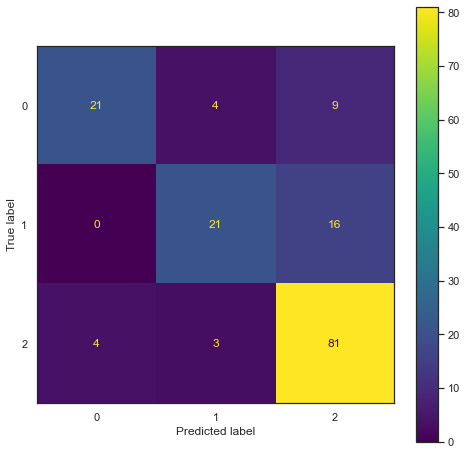

In [19]:
sns.set_theme(style='white')
fig, ax = plt.subplots(1,1,figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)

In [20]:
text = [["ngân_hàng thích_ứng với trạng_thái bình_thường sau đại_dịch"],
        ["để xảy_ra thất_thoát tại sân_bay Long Thành"],
        ['Camera an ninh: Giật dây chuyền bất thành'],
        ["tổn thất"],
        ['lãi kỷ lục'],
        ['Những xã nào được quyền cấp đăng ký xe máy'],
        ['Ông Putin khen thưởng lữ đoàn từng kiểm soát Bucha']]

for i in text:
  test = tf.transform(i)
  print(model.predict(test))

[2]
[1]
[0]
[0]
[2]
[2]
[2]
